<a href="https://colab.research.google.com/github/GVK1992/Adaptive-Ensemble-IDS-IoT/blob/main/Code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive

In [2]:

drive.mount('/content/drive')

# changing directory to the dataset folder
os.chdir('/content/drive/My Drive/Colab Notebooks/Capstone')

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Code2.ipynb  lgbm.joblib	rf.joblib			  sgd.joblib
Code.ipynb   merged_output.csv	selected_features_with_label.csv  xgb.joblib


In [3]:
final_data=pd.read_csv('selected_features_with_label.csv')

In [4]:
final_data.head()

,Destination_Port,Flow_Duration,Fwd_Packet_Length_Max,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,Bwd_Packet_Length_Min,Bwd_Packet_Length_Mean,Flow_IAT_Max,Fwd_IAT_Max,Bwd_IAT_Total,...,Packet_Length_Variance,PSH_Flag_Count,ACK_Flag_Count,URG_Flag_Count,Down_Up_Ratio,Avg_Bwd_Segment_Size,Init_Win_bytes_backward,Active_Max,Idle_Max,Label
0,54865,3,6,0.0,0,0,0.0,3,3,0,...,0.0,0,1,0,0,0.0,-1,0,0,1
1,55054,109,6,0.0,6,6,6.0,109,0,0,...,0.0,0,1,1,1,6.0,256,0,0,1
2,55055,52,6,0.0,6,6,6.0,52,0,0,...,0.0,0,1,1,1,6.0,256,0,0,1
3,46236,34,6,0.0,6,6,6.0,34,0,0,...,0.0,0,1,1,1,6.0,329,0,0,1
4,54863,3,6,0.0,0,0,0.0,3,3,0,...,0.0,0,1,0,0,0.0,-1,0,0,1


In [5]:
#import statements for base models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb

In [6]:
#splitting data into train and test.
X = final_data.drop(columns=['Label'])
y = final_data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training Time: 60.56 seconds
Prediction Time: 0.56 seconds
Accuracy: 0.9945
Precision: 0.9945
Recall: 0.9945
F1-score: 0.9945

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    111487
           1       1.00      1.00      1.00    454089

    accuracy                           0.99    565576
   macro avg       0.99      0.99      0.99    565576
weighted avg       0.99      0.99      0.99    565576



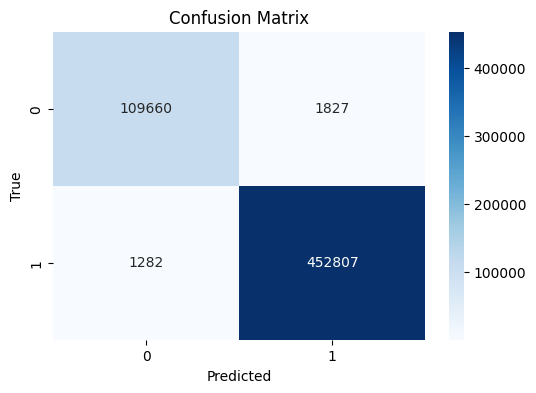

['rf.joblib']

In [7]:
# Initialising and training random forest
start_train_time = time.time()
rf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
end_train_time = time.time()
train_time = end_train_time - start_train_time
print(f"Training Time: {train_time:.2f} seconds")

# Predicting model for test data
start_pred_time = time.time()
y_pred = rf.predict(X_test)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time
print(f"Prediction Time: {pred_time:.2f} seconds")


#Metrics values
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

dump(rf, 'rf.joblib')


In [8]:
#checking metrics on test and train datasets to verify overfitting
# Train predictions
y_train_pred = rf.predict(X_train)

# Test predictions
y_test_pred = rf.predict(X_test)

# accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", round(train_accuracy, 4))
print("Test Accuracy:", round(test_accuracy, 4))

#Classification report for test set
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))


Train Accuracy: 0.9945
Test Accuracy: 0.9945

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    111487
           1       1.00      1.00      1.00    454089

    accuracy                           0.99    565576
   macro avg       0.99      0.99      0.99    565576
weighted avg       0.99      0.99      0.99    565576



In [9]:
# Building SGD Pipeline and including Scaling
sgd_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling for normalisation
    ('sgd', SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=0.0001,
        max_iter=300,
        early_stopping=True,
        n_iter_no_change=5,
        class_weight='balanced',
        random_state=42
    ))
])

#Training Model
start_time = time.time()
sgd_pipeline.fit(X_train, y_train)
train_time = time.time() - start_time

#Predicting on Test dataset
start_pred = time.time()
y_pred = sgd_pipeline.predict(X_test)
pred_time = time.time() - start_pred

# Metrics caluculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Results
print(f"Training Time: {train_time:.2f} seconds")
print(f"Prediction Time: {pred_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}\n")

#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
dump(sgd_pipeline, 'sgd.joblib')

Training Time: 5.26 seconds
Prediction Time: 0.11 seconds
Accuracy: 0.8940
Precision: 0.9229
Recall: 0.8940
F1-score: 0.9006

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.95      0.78    111487
           1       0.99      0.88      0.93    454089

    accuracy                           0.89    565576
   macro avg       0.82      0.92      0.86    565576
weighted avg       0.92      0.89      0.90    565576



['sgd.joblib']

In [10]:
# Computing class weight ration to handle class imbalance
anamoly_class = np.sum(y_train == 0)
benign_class = np.sum(y_train == 1)
class_weight_ratio = anamoly_class / benign_class

# Initializing LightGBM model
lgbm = lgb.LGBMClassifier(
    learning_rate=0.05,
    num_leaves=31,
    scale_pos_weight=class_weight_ratio,
    n_estimators=500,
    random_state=42
)

#Training the model
start_train=time.time()
lgbm.fit(X_train, y_train)
end_train = time.time()
train_time = end_train - start_train
print(f"Training Time: {train_time:.2f} seconds")

#Predicting on test dataset
start_pred=time.time()
y_pred = lgbm.predict(X_test)
end_pred = time.time()
pred_time = end_pred - start_pred
print(f"Prediction Time: {pred_time:.2f} seconds")

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

#results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

#Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
dump(lgbm, 'lgbm.joblib')

[LightGBM] [Info] Number of positive: 1817231, number of negative: 445069
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3958
[LightGBM] [Info] Number of data points in the train set: 2262300, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803267 -> initscore=1.406840
[LightGBM] [Info] Start training from score 1.406840
Training Time: 26.91 seconds
Prediction Time: 3.18 seconds
Accuracy: 0.9942
Precision: 0.9943
Recall: 0.9942
F1-score: 0.9943

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    111487
           1       1.00      0.99      1.00    454089

    accuracy                           0.99    565576
   macro avg       0.99      1.00      0.99    565576
weighted avg     

['lgbm.joblib']

In [11]:
# Initializing and Training the XGBoost Model
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

start_time = time.time()
xgb_model.fit(X_train, y_train)
train_time = time.time() - start_time

#Predicting on test dataset
start_time = time.time()
y_pred = xgb_model.predict(X_test)
prediction_time = time.time() - start_time

#Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Training Time: {train_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}\n")

#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

#Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
dump(xgb_model, 'xgb.joblib')

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:45:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Time: 7.02 seconds
Prediction Time: 0.19 seconds
Accuracy: 0.9953
Precision: 0.9963
Recall: 0.9979
F1-score: 0.9971

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    111487
           1       1.00      1.00      1.00    454089

    accuracy                           1.00    565576
   macro avg       0.99      0.99      0.99    565576
weighted avg       1.00      1.00      1.00    565576

Confusion Matrix:
[[109791   1696]
 [   952 453137]]


['xgb.joblib']

In [12]:
print("Training Accuracy:", xgb_model.score(X_train, y_train))
print("Test Accuracy:", xgb_model.score(X_test, y_test))


Training Accuracy: 0.9953025681828228
Test Accuracy: 0.9953180474418999


In [14]:
#importing libraries for meta learner model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from river.forest import ARFClassifier

In [15]:
# Defining meta-learner
meta_learner = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)

# Defining stacked model
stacked_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('sgd', sgd_pipeline),
        ('lgbm', lgbm),
        ('xgb', xgb_model)
    ],
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

# Training stacked model on train dataset
stacked_model.fit(X_train, y_train)

#Predicting on test dataset
y_pred = stacked_model.predict(X_test)

#metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}\n")

#Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

#Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9958
Precision: 0.9958
Recall: 0.9958
F1-score: 0.9958

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    111487
           1       1.00      1.00      1.00    454089

    accuracy                           1.00    565576
   macro avg       0.99      0.99      0.99    565576
weighted avg       1.00      1.00      1.00    565576

Confusion Matrix:
[[110264   1223]
 [  1144 452945]]


In [16]:
#Creating a stacked meta model including the cross validation to reduce overfitting
# Initialisaing Meta-learner
meta_learner = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=1000)

# Initialising Stacking model
stacked_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('sgd', sgd_pipeline),
        ('lgbm', lgbm),
        ('xgb', xgb_model)
    ],
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=True
)


# Cross-Validation

print("Performing 5-Fold Cross Validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_cv = time.time()
cv_scores = cross_val_score(stacked_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
end_cv = time.time()

print("\nCross-Validation Results:")
print(f"Fold Accuracies: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Cross-Validation Time: {end_cv - start_cv:.2f} seconds")


# Training on Train dataset
print("\nTraining Stacked Model")
start_train = time.time()
stacked_model.fit(X_train, y_train)
end_train = time.time()

print(f"Training Time: {end_train - start_train:.2f} seconds")

#Predicting stacked model on test dataset
start_pred = time.time()
y_pred = stacked_model.predict(X_test)
end_pred = time.time()

print(f"Prediction Time: {end_pred - start_pred:.2f} seconds")

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Performing 5-Fold Cross Validation...

Cross-Validation Results:
Fold Accuracies: [0.88579322 0.88242939 0.8833908  0.88679441 0.88286478]
Mean Accuracy: 0.8843
Cross-Validation Time: 8616.23 seconds

Training Stacked Model


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Time: 887.69 seconds
Prediction Time: 4.38 seconds
Accuracy: 0.8922
Precision: 0.8862
Recall: 0.9933
F1-score: 0.9367

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.48      0.64    111487
           1       0.89      0.99      0.94    454089

    accuracy                           0.89    565576
   macro avg       0.92      0.74      0.79    565576
weighted avg       0.90      0.89      0.88    565576


Confusion Matrix:
[[ 53540  57947]
 [  3035 451054]]


In [17]:
# !pip install river==0.22.0


In [18]:
#Updating SGD Pipeline to utilize Log Loss

sgd_pipeline = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
)
sgd_pipeline.fit(X_train, y_train)


#Taking subset for meta model training
subset_size = 100_000
X_meta_pool, _, y_meta_pool, _ = train_test_split(
    X_train, y_train, train_size=subset_size, stratify=y_train, random_state=42
)

#Spliting the  meta pool into meta-train and meta-valid
X_meta_train, X_meta_valid, y_meta_train, y_meta_valid = train_test_split(
    X_meta_pool, y_meta_pool, test_size=0.2, stratify=y_meta_pool, random_state=42
)

#Function for extracting positive class probabilities safely
def pos_proba(model, X):
    proba = model.predict_proba(X)
    if hasattr(model, 'classes_'):
        if list(model.classes_) == [0, 1]:
            return proba[:, 1]
        else:
            pos_idx = np.where(model.classes_ == 1)[0][0]
            return proba[:, pos_idx]
    return proba[:, 1]

#Building meta features from pre-trained base models
meta_train = pd.DataFrame({
    'rf':  pos_proba(rf, X_meta_train),
    'sgd': pos_proba(sgd_pipeline, X_meta_train),
    'lgb': pos_proba(lgbm, X_meta_train),
    'xgb': pos_proba(xgb_model, X_meta_train),
})

meta_valid = pd.DataFrame({
    'rf':  pos_proba(rf, X_meta_valid),
    'sgd': pos_proba(sgd_pipeline, X_meta_valid),
    'lgb': pos_proba(lgbm, X_meta_valid),
    'xgb': pos_proba(xgb_model, X_meta_valid),
})

#Meta-learner
meta_learner = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=1000)
meta_learner.fit(meta_train, y_meta_train)

#evaluation on meta-valid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
meta_pred = (meta_learner.predict_proba(meta_valid)[:, 1] >= 0.5).astype(int)
print(
    "Meta-only (valid) | "
    f"Acc: {accuracy_score(y_meta_valid, meta_pred):.4f} "
    f"P: {precision_score(y_meta_valid, meta_pred):.4f} "
    f"R: {recall_score(y_meta_valid, meta_pred):.4f} "
    f"F1: {f1_score(y_meta_valid, meta_pred):.4f}"
)


Meta-only (valid) | Acc: 0.9961 P: 0.9973 R: 0.9979 F1: 0.9976


In [19]:
#Evaluation the meta model on Test dataset
from sklearn.metrics import classification_report, confusion_matrix

meta_test = pd.DataFrame({
    'rf':  pos_proba(rf, X_test),
    'sgd': pos_proba(sgd_pipeline, X_test),
    'lgb': pos_proba(lgbm, X_test),
    'xgb': pos_proba(xgb_model, X_test),
})

stack_proba = meta_learner.predict_proba(meta_test)[:, 1]
y_pred = (stack_proba >= 0.5).astype(int)
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy:  0.9957
Precision: 0.9969
Recall:    0.9977
F1-score:  0.9973

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    111487
           1       1.00      1.00      1.00    454089

    accuracy                           1.00    565576
   macro avg       0.99      0.99      0.99    565576
weighted avg       1.00      1.00      1.00    565576

Confusion Matrix:
[[110097   1390]
 [  1037 453052]]


Meta Validation Log Loss: 0.0124
Meta Test Log Loss:       0.0138
Meta Validation ROC-AUC: 0.9998
Meta Test ROC-AUC:       0.9997


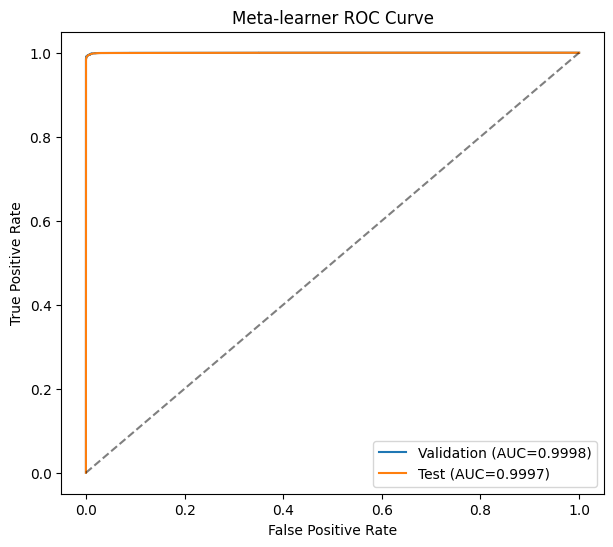

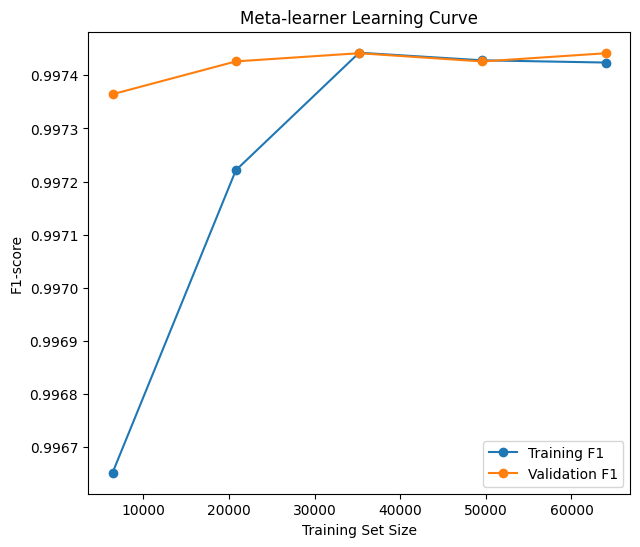

In [20]:
#probabilistic evaluation and ROC-AUC curve
# Predictions for Meta-validation
meta_valid_pred_proba = meta_learner.predict_proba(meta_valid)[:, 1]
meta_test = pd.DataFrame({
    'rf':  pos_proba(rf, X_test),
    'sgd': pos_proba(sgd_pipeline, X_test),
    'lgb': pos_proba(lgbm, X_test),
    'xgb': pos_proba(xgb_model, X_test),
})
meta_test_pred_proba = meta_learner.predict_proba(meta_test)[:, 1]

#Log Loss
ll_valid = log_loss(y_meta_valid, meta_valid_pred_proba)
ll_test = log_loss(y_test, meta_test_pred_proba)
print(f"Meta Validation Log Loss: {ll_valid:.4f}")
print(f"Meta Test Log Loss:       {ll_test:.4f}")

#ROC-AUC
auc_valid = roc_auc_score(y_meta_valid, meta_valid_pred_proba)
auc_test = roc_auc_score(y_test, meta_test_pred_proba)
print(f"Meta Validation ROC-AUC: {auc_valid:.4f}")
print(f"Meta Test ROC-AUC:       {auc_test:.4f}")

#ROC Curve
fpr_valid, tpr_valid, _ = roc_curve(y_meta_valid, meta_valid_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, meta_test_pred_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr_valid, tpr_valid, label=f'Validation (AUC={auc_valid:.4f})')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC={auc_test:.4f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Meta-learner ROC Curve')
plt.legend()
plt.show()

#Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    meta_learner, meta_train, y_meta_train,
    cv=5, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(7,6))
plt.plot(train_sizes, train_mean, 'o-', label='Training F1')
plt.plot(train_sizes, val_mean, 'o-', label='Validation F1')
plt.xlabel('Training Set Size')
plt.ylabel('F1-score')
plt.title('Meta-learner Learning Curve')
plt.legend()
plt.show()


In [21]:
#including cross validation

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []
log_losses, auc_scores = [], []

X_meta = meta_train.values
y_meta = y_meta_train.values

for train_idx, val_idx in cv.split(X_meta, y_meta):
    X_tr, X_val = X_meta[train_idx], X_meta[val_idx]
    y_tr, y_val = y_meta[train_idx], y_meta[val_idx]

    # Training meta-learner
    meta_learner_cv = LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000)
    meta_learner_cv.fit(X_tr, y_tr)

    # Predictions
    y_val_pred = meta_learner_cv.predict(X_val)
    y_val_proba = meta_learner_cv.predict_proba(X_val)[:, 1]

    # Metrics
    acc_scores.append(accuracy_score(y_val, y_val_pred))
    prec_scores.append(precision_score(y_val, y_val_pred))
    rec_scores.append(recall_score(y_val, y_val_pred))
    f1_scores.append(f1_score(y_val, y_val_pred))
    log_losses.append(log_loss(y_val, y_val_proba))
    auc_scores.append(roc_auc_score(y_val, y_val_proba))

print("Cross-Validated Metrics (5 folds):")
print(f"Accuracy:  {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"Precision: {np.mean(prec_scores):.4f} ± {np.std(prec_scores):.4f}")
print(f"Recall:    {np.mean(rec_scores):.4f} ± {np.std(rec_scores):.4f}")
print(f"F1-score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Log Loss:  {np.mean(log_losses):.4f} ± {np.std(log_losses):.4f}")
print(f"ROC-AUC:   {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")


Cross-Validated Metrics (5 folds):
Accuracy:  0.9959 ± 0.0006
Precision: 0.9969 ± 0.0004
Recall:    0.9980 ± 0.0006
F1-score:  0.9974 ± 0.0004
Log Loss:  0.0135 ± 0.0015
ROC-AUC:   0.9997 ± 0.0001


In [22]:
#Adding Online random forest into the meta learner model
try:
    from river.forest import ARFClassifier
    arf = ARFClassifier(
        n_models=10, max_features='sqrt', seed=42
    )

    #Traing ORF on train dataset in batches
    def stream_rows(dfX, sY):
        for xi, yi in zip(dfX.to_dict(orient='records'), sY):
            yield xi, yi

    def train_arf_incremental(arf_model, X, y, batch_size=50_000):
        n = len(X)
        for i in range(0, n, batch_size):
            Xb = X.iloc[i:i+batch_size]
            yb = y.iloc[i:i+batch_size]
            for xi, yi in stream_rows(Xb, yb):
                arf_model.learn_one(xi, int(yi))
        return arf_model

    t0 = time.time()
    arf = train_arf_incremental(arf, X_train, y_train, batch_size=50_000)
    print(f"ARF incremental training done in {time.time()-t0:.1f}s")

    # function to get positive probability for ARF
    def river_pos_proba(arf_model, X):
        out = np.empty(len(X), dtype=float)
        for idx, xi in enumerate(X.to_dict(orient='records')):
            proba_dict = arf_model.predict_proba_one(xi)
            out[idx] = proba_dict.get(1, 0.0)
        return out

    # Adding ORF to meta learner model anf training it
    arf_meta_train = river_pos_proba(arf, X_meta_train)
    arf_meta_valid = river_pos_proba(arf, X_meta_valid)
    arf_meta_test  = river_pos_proba(arf, X_test)

    meta_train_ar = meta_train.copy(); meta_train_ar['arf'] = arf_meta_train
    meta_valid_ar = meta_valid.copy(); meta_valid_ar['arf'] = arf_meta_valid
    meta_test_ar  = meta_test.copy();  meta_test_ar['arf']  = arf_meta_test

    # Refiting meta-learner on augmented features
    meta_learner.fit(meta_train_ar, y_meta_train)
    meta_pred_valid = (meta_learner.predict_proba(meta_valid_ar)[:,1] >= 0.5).astype(int)
    print(
        "Meta-learner including ORF:  "
        f"Acc: {accuracy_score(y_meta_valid, meta_pred_valid):.4f} "
        f"P: {precision_score(y_meta_valid, meta_pred_valid):.4f} "
        f"R: {recall_score(y_meta_valid, meta_pred_valid):.4f} "
        f"F1: {f1_score(y_meta_valid, meta_pred_valid):.4f}"
    )

    #Predicting with ORF included stacking
    y_pred_ar = (meta_learner.predict_proba(meta_test_ar)[:,1] >= 0.5).astype(int)
    print("\nStacked + ARF — Test Metrics")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred_ar):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_ar):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred_ar):.4f}")
    print(f"F1-score:  {f1_score(y_test, y_pred_ar):.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred_ar))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_ar))

except Exception as e:
    print("Skipping ORF (River) step due to error:", repr(e))


ARF incremental training done in 3050.3s
Meta-learner including ORF:  Acc: 0.9960 P: 0.9974 R: 0.9976 F1: 0.9975

Stacked + ARF — Test Metrics
Accuracy:  0.9957
Precision: 0.9970
Recall:    0.9976
F1-score:  0.9973

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    111487
           1       1.00      1.00      1.00    454089

    accuracy                           1.00    565576
   macro avg       0.99      0.99      0.99    565576
weighted avg       1.00      1.00      1.00    565576

Confusion Matrix:
[[110145   1342]
 [  1083 453006]]


In [23]:
# pip install --upgrade river


In [26]:
from river.linear_model import LogisticRegression

#Including Cross validation alog with Online Random Forest into meta learner
# As the river model needs dictionaries, converting the data into dictionaries
X_np = X_train.to_numpy()
y_np = y_train.to_numpy()
X_dicts = [dict(enumerate(row)) for row in X_np]  # river needs dict features

#Initialising new base learner ARF
arf = ARFClassifier(n_models=10, seed=42)

# Meta-learner
meta_learner = LogisticRegression()

#Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_metrics = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_np, y_np), 1):
    print(f"Fold {fold}")

    # Reset models for each fold
    arf_fold = ARFClassifier(n_models=10, seed=42)
    meta_fold = LogisticRegression()

    # Preparing train/valid splits
    X_train_fold = [X_dicts[i] for i in train_idx]
    y_train_fold = y_np[train_idx]

    X_valid_fold = [X_dicts[i] for i in valid_idx]
    y_valid_fold = y_np[valid_idx]

    # Step 1: Train base ARF incrementally
    base_preds_train = []
    for x, y in zip(X_train_fold, y_train_fold):
        pred = arf_fold.predict_one(x)
        arf_fold.learn_one(x, y)
        base_preds_train.append(pred if pred is not None else 0)  # fallback

    # Step 2: Train meta-learner
    meta_X_train = [{'arf_pred': p} for p in base_preds_train]
    for x_meta, y_meta in zip(meta_X_train, y_train_fold):
        meta_fold.learn_one(x_meta, y_meta)

    # Step 3: Validate
    base_preds_valid = [arf_fold.predict_one(x) or 0 for x in X_valid_fold]
    meta_X_valid = [{'arf_pred': p} for p in base_preds_valid]

    y_pred_valid = [meta_fold.predict_one(x) or 0 for x in meta_X_valid]

    # Metrics
    acc = accuracy_score()
    prec = precision_score()
    rec = recall_score()
    f1 = f1_score()

    for y_true, y_hat in zip(y_valid_fold, y_pred_valid):
        acc.update(y_true, y_hat)
        prec.update(y_true, y_hat)
        rec.update(y_true, y_hat)
        f1.update(y_true, y_hat)

    print(f"Fold {fold} | Acc: {acc.get():.4f} P: {prec.get():.4f} R: {rec.get():.4f} F1: {f1.get():.4f}")
    cv_metrics.append((acc.get(), prec.get(), rec.get(), f1.get()))

# Average CV metrics
avg_metrics = np.mean(cv_metrics, axis=0)
print("\n=== Average CV Metrics ===")
print(f"Acc: {avg_metrics[0]:.4f} P: {avg_metrics[1]:.4f} R: {avg_metrics[2]:.4f} F1: {avg_metrics[3]:.4f}")


Fold 1


TypeError: missing a required argument: 'y_true'

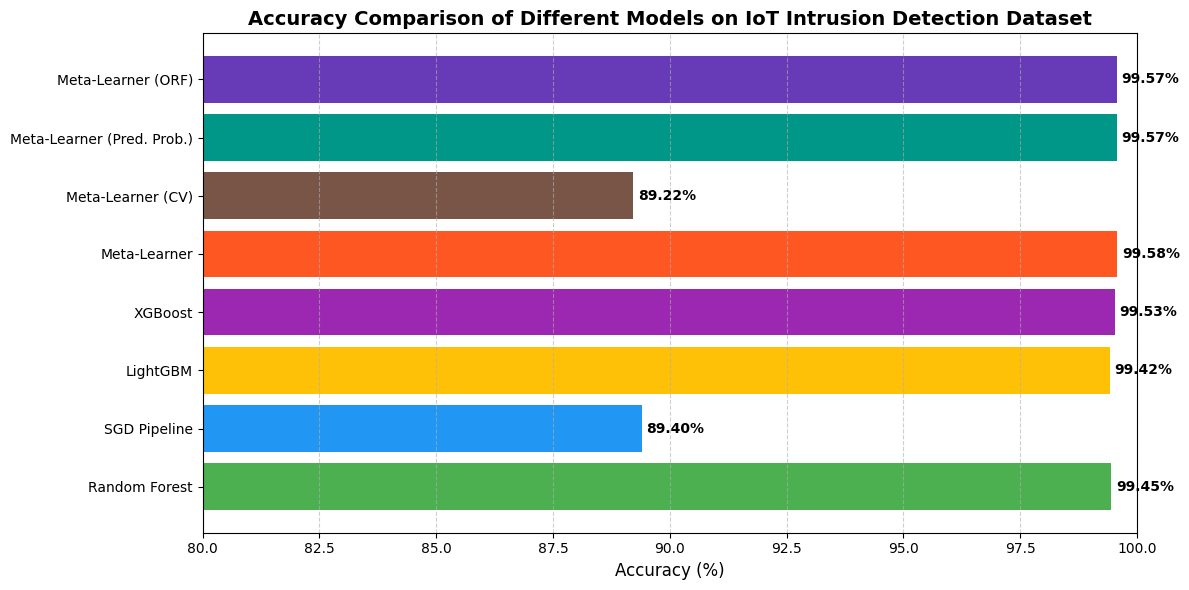

In [27]:
import matplotlib.pyplot as plt

# Models and corresponding accuracy values
models = [
    'Random Forest',
    'SGD Pipeline',
    'LightGBM',
    'XGBoost',
    'Meta-Learner',
    'Meta-Learner (CV)',
    'Meta-Learner (Pred. Prob.)',
    'Meta-Learner (ORF)'
]

accuracy = [99.45, 89.40, 99.42, 99.53, 99.58, 89.22, 99.57, 99.57]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(models, accuracy, color=['#4CAF50', '#2196F3', '#FFC107', '#9C27B0', '#FF5722', '#795548', '#009688', '#673AB7'])

# Add accuracy values on bars
for bar, acc in zip(bars, accuracy):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'{acc:.2f}%', va='center', fontsize=10, fontweight='bold')

# Labels and title
plt.xlabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy Comparison of Different Models on IoT Intrusion Detection Dataset', fontsize=14, fontweight='bold')
plt.xlim(80, 100)  # focus on the relevant range
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
